In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
%matplotlib inline

import os
import numpy as np
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
# 데이터 경로 지정
path2data = './data'
os.makedirs(path2data, exist_ok=True) # 폴더 생성

In [4]:
# MNIST dataset 불러오기
train_ds = datasets.MNIST(path2data, train=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5],[0.5])]), download=True)

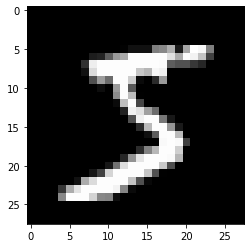

In [5]:
# 샘플 이미지 확인
img, label = train_ds[0]
plt.imshow(to_pil_image(0.5*img+0.5),cmap='gray')

In [6]:
# 데이터 로더 생성
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

In [7]:
# check
for x, y in train_dl:
    print(x.shape, y.shape)
    break

torch.Size([32, 1, 28, 28]) torch.Size([32])


In [8]:
# generator: noise를 입력받아 이미지를 생성합니다.
class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.nz = params['nz'] # 입력 노이즈 벡터 수, 100
        self.img_size = params['img_size'] # 이미지 크기, 1x28x28

        self.model = nn.Sequential(
            *self._fc_layer(self.nz, 128, normalize=False),
            *self._fc_layer(128,256),
            *self._fc_layer(256,512),
            *self._fc_layer(512,1024),
            nn.Linear(1024,int(np.prod(self.img_size))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_size)
        return img

    # fc layer
    def _fc_layer(self, in_channels, out_channels, normalize=True):
        layers = []
        layers.append(nn.Linear(in_channels, out_channels)) # fc layer
        if normalize:
            layers.append(nn.BatchNorm1d(out_channels, 0.8)) # BN
        layers.append(nn.LeakyReLU(0.2)) # LeakyReLU
        return layers

# check
params = {'nz':100,
          'img_size':(1,28,28)}
x = torch.randn(16,100).to(device) # random noise
model_gen = Generator(params).to(device)
output = model_gen(x) # noise를 입력받아 이미지 생성
print(output.shape)

torch.Size([16, 1, 28, 28])


In [9]:
# discriminator: 진짜 이미지와 가짜 이미지를 분류합니다.
class Discriminator(nn.Module):
    def __init__(self,params):
        super().__init__()
        self.img_size = params['img_size'] # 이미지 크기, 1x28x28

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(self.img_size)), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0),-1)
        x = self.model(x)
        return x

# check
x = torch.randn(16,1,28,28).to(device)
model_dis = Discriminator(params).to(device)
output = model_dis(x)
print(output.shape)

torch.Size([16, 1])


In [10]:
# 가중치 초기화
def initialize_weights(model):
    classname = model.__class__.__name__
    # fc layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# 가중치 초기화 적용
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

In [11]:
# 손실 함수
loss_func = nn.BCELoss()

In [12]:
from torch import optim

# 최적화 파라미터
lr = 2e-4
beta1 = 0.5

opt_dis = optim.Adam(model_dis.parameters(),lr=lr,betas=(beta1,0.999))
opt_gen = optim.Adam(model_gen.parameters(),lr=lr,betas=(beta1,0.999))

In [13]:
real_label = 1.
fake_label = 0.
nz = params['nz']
num_epochs = 1

loss_history={'gen':[],
              'dis':[]}

In [14]:

batch_count = 0
start_time = time.time()
model_dis.train()
model_gen.train()

for epoch in range(num_epochs):
    for xb, yb in train_dl:
        ba_si = xb.size(0)

        xb = xb.to(device)
        yb_real = torch.Tensor(ba_si,1).fill_(1.0).to(device)
        yb_fake = torch.Tensor(ba_si,1).fill_(0.0).to(device)

        # Generator
        model_gen.zero_grad()
        noise = torch.randn(ba_si,nz, device=device) # 노이즈 생성
        out_gen = model_gen(noise) # 가짜 이미지 생성
        out_dis = model_dis(out_gen) # 가짜 이미지 판별

        loss_gen = loss_func(out_dis, yb_real)
        loss_gen.backward()
        opt_gen.step()

        # Discriminator
        model_dis.zero_grad()

        out_real = model_dis(xb) # 진짜 이미지 판별
        out_fake = model_dis(out_gen.detach()) # 가짜 이미지 판별
        loss_real = loss_func(out_real, yb_real)
        loss_fake = loss_func(out_fake, yb_fake)
        loss_dis = (loss_real + loss_fake) / 2

        loss_dis.backward()
        opt_dis.step()

        loss_history['gen'].append(loss_gen.item())
        loss_history['dis'].append(loss_dis.item())

        batch_count += 1
        if batch_count % 1000 == 0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, loss_gen.item(), loss_dis.item(), (time.time()-start_time)/60))

Epoch: 0, G_Loss: 2.124063, D_Loss: 0.351925, time: 0.19 min


In [1]:
# plot loss history
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_history['gen'], label='Gen. Loss')
plt.plot(loss_history['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [15]:
# 가중치 저장
path2models = './models/'
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'weights_gen.pt')
path2weights_dis = os.path.join(path2models, 'weights_dis.pt')

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

In [16]:
# 가중치 불러오기
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)

# evaluation mode
model_gen.eval()

# 가짜 이미지 생성
with torch.no_grad():
    fixed_noise = torch.randn(16, 100, device=device)
    img_fake = model_gen(fixed_noise).detach().cpu()
print(img_fake.shape)

torch.Size([16, 1, 28, 28])


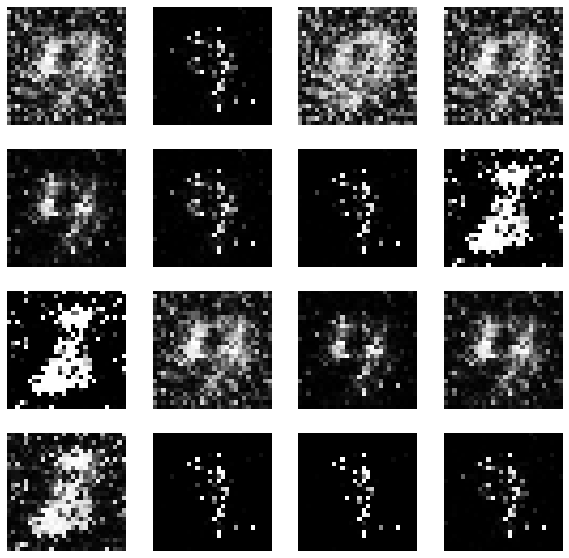

In [17]:
# 가짜 이미지 시각화
plt.figure(figsize=(10,10))
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*img_fake[ii]+0.5),cmap='gray')
    plt.axis('off')